#### Apply mobilenet_v2 pretrained model from google's Tensorflow Hub and re-train that on flowers dataset

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE=(224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
cock=Image.open('cock.jpg').resize(IMAGE_SHAPE)

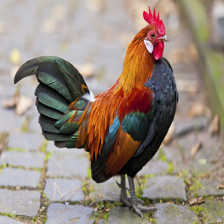

In [5]:
cock

In [6]:
cock=np.array(cock)/255
cock.shape

(224, 224, 3)

In [7]:
cock[np.newaxis, ...].shape

(1, 224, 224, 3)

In [8]:
result=classifier.predict(cock[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
predict_label_index=np.argmax(result)
predict_label_index

8

In [10]:
image_labels=[]
with open("ImageNetLabels.txt") as f:
    image_labels=f.read().splitlines()
image_labels[:4]

['background', 'tench', 'goldfish', 'great white shark']

In [11]:
image_labels[8]

'cock'

### Load flower dataset 

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
#'.' local directory downloading the unzip flower photos. The data and url is frok tensorflow.org website

In [13]:
data_dir

'.\\datasets\\flower_photos'

In [14]:
import pathlib
data_dir=pathlib.Path(data_dir) #this is a string path need to be converted to windows path
data_dir

WindowsPath('datasets/flower_photos')

In [15]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [16]:
image_count=len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [17]:
roses=list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

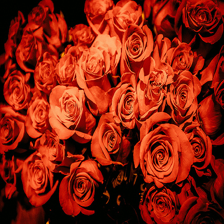

In [18]:
Image.open(str(roses[2])).resize(IMAGE_SHAPE)

                 

In [19]:
tulips=list(data_dir.glob('tulips/*'))
tulips[:5]

[WindowsPath('datasets/flower_photos/tulips/100930342_92e8746431_n.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094729603_eeca3f2cb6.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094731133_94a942463c.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10128546863_8de70c610d.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10163955604_ae0b830975_n.jpg')]

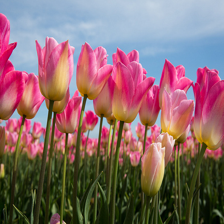

In [20]:
Image.open(str(tulips[3])).resize(IMAGE_SHAPE)

In [21]:
flowers_images_dict={'roses':list(data_dir.glob('roses/*')),
                     'daisy':list(data_dir.glob('daisy/*')),
                     'dandelion':list(data_dir.glob('dandelion/*')),
                    'sunflower':list(data_dir.glob('sunflower/*')),
                    'tulips':list(data_dir.glob('tulips/*'))}

In [22]:
flowers_label_dict={'roses':0,
                   'daisy':1,
                   'dandelion':2,
                   'sunflower':3,
                   'tulips':4}

In [23]:
X,y=[],[]

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        resized_image=cv2.resize(img,(224,224))
        X.append(resized_image)
        y.append(flowers_label_dict[flower_name])
        

In [24]:
X=np.array(X)
y=np.array(y)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=42)


In [26]:
X_trained_scaled=X_train/255
X_test_scaled=X_test/255

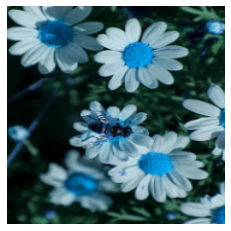

In [27]:
plt.axis('off')
plt.imshow(X[723])

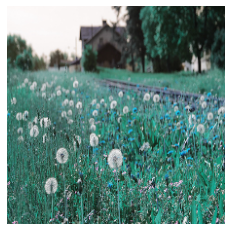

In [28]:
plt.axis('off')
plt.imshow(X[2123])

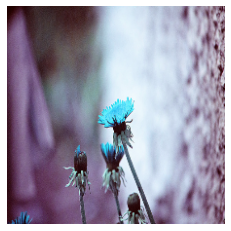

In [29]:
plt.axis('off')
plt.imshow(X[2000])

In [30]:
x0_resized=cv2.resize(X[723],IMAGE_SHAPE)
x1_resized=cv2.resize(X[2123],IMAGE_SHAPE)
x2_resized=cv2.resize(X[2000],IMAGE_SHAPE)

In [31]:
predicted=classifier.predict(np.array([x0_resized,x1_resized,x2_resized]))
predicted=np.argmax(predicted,axis=1)

In [32]:
predicted

array([550, 795, 795], dtype=int64)

In [33]:
image_labels[550]

'envelope'

### It didnt predict well, we will be using the "feature vector model" in which the depth layer is freezed and the output layer is removed and can be replaced 

In [35]:
feature_extractor_model="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"
pretrained_model_without_output_layer=hub.KerasLayer(feature_extractor_model,input_shape=(224,224,3),trainable=False)

In [37]:
num_of_flowers=5
model_new=tf.keras.Sequential([pretrained_model_without_output_layer,tf.keras.layers.Dense(num_of_flowers)])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
model_new.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

model_new.fit(X_trained_scaled,y_train,epochs=10)

Epoch 1/10
70/70 [==============================] - 30s 436ms/step - loss: 0.6442 - acc: 0.7518
Epoch 2/10
70/70 [==============================] - 34s 480ms/step - loss: 0.3397 - acc: 0.8766
Epoch 3/10
70/70 [==============================] - 34s 484ms/step - loss: 0.2654 - acc: 0.9093
Epoch 4/10
70/70 [==============================] - 34s 479ms/step - loss: 0.2250 - acc: 0.9246
Epoch 5/10
70/70 [==============================] - 34s 485ms/step - loss: 0.1937 - acc: 0.9412
Epoch 6/10
70/70 [==============================] - 34s 483ms/step - loss: 0.1690 - acc: 0.9524
Epoch 7/10
70/70 [==============================] - 34s 483ms/step - loss: 0.1566 - acc: 0.9565
Epoch 8/10
70/70 [==============================] - 34s 485ms/step - loss: 0.1362 - acc: 0.9659
Epoch 9/10
70/70 [==============================] - 39s 553ms/step - loss: 0.1223 - acc: 0.9677
Epoch 10/10
70/70 [==============================] - 39s 554ms/step - loss: 0.1109 - acc: 0.9753


In [44]:
model_new.evaluate(X_test_scaled,y_test)

24/24 [==============================] - 9s 374ms/step - loss: 0.2898 - acc: 0.8937


[0.28982028365135193, 0.8936743140220642]

In [45]:
predicted_new=model_new.predict(np.array([x0_resized,x1_resized,x2_resized]))
predicted_new=np.argmax(predicted_new,axis=1)

In [46]:
predicted_new

array([1, 2, 2], dtype=int64)

In [49]:
image_labels[2]

'goldfish'